# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

$\min \; Z =
\underbrace{
w_{\text{main}} \cdot \left(
w_t \cdot \sum_{j \in \mathcal{J}} T_j
+ w_e \cdot \sum_{j \in \mathcal{J}} E_j
+ w_{\text{first}} \cdot \sum_{j \in \mathcal{J}} F_j
\right)
}_{\text{Lateness-Komponente}}
\; + \;
\underbrace{
(1 - w_{\text{main}}) \cdot \sum_{(j,o) \in \mathcal{P}} D_{jo}
}_{\text{Abweichungskomponente}}$

$\mathcal{J}$ … Menge aller Jobs
$\mathcal{P}$ … Menge aller Operationen mit vorherigem Planbezug

$T_j = \max(0, \text{Ende}_j - \text{Deadline}_j)$ … Tardiness (Verspätung)
$E_j = \max(0, \text{Deadline}_j - \text{Ende}_j)$ … Earliness (zu früh)
$F_j = \max(0, \text{Wunschstart}_j - \text{Start}_{j,0})$ … Frühstartstrafe der ersten Operation

$D_{jo} =
\begin{cases}
|S_{jo}^{\text{neu}} - S_{jo}^{\text{alt}}| & \text{(Startzeitabweichung)} \\
\text{Anzahl der Inversionen (Kendall-Tau)} & \text{(Reihenfolgeabweichung)}
\end{cases}$


In [1]:
import pandas as pd

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.rolling_process.rolling_filter import *
from src.utils.editor import enrich_schedule_dframe

from src.utils.logging import print_experiment_log

# Analysis utils
from src.utils.analysis_basics import check_constraints as check
from src.utils.analysis_basics.check_lateness import get_jobs_with_lateness_metrics, get_jobs_aggregated
from src.utils.analysis.compare_sequences import get_comparison_dataframe, compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Solver
from src.solvers.converter import get_job_ops_dict, get_times_dict, get_schedule_dframe, get_active_ops
from src.solvers.cp.lateness import solve_jssp_lateness_with_start_deviation_minimization, \
    solve_jssp_lateness_with_order_deviation_minimization

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
from classes.Workflow import JobOperationWorkflowCollection
from classes.Problem import JobOperationProblemCollection
from classes.JobInformation import JobInformationCollection
from classes.Routing import RoutingOperationCollection

In [3]:
# Hard termination condition for schedulers
max_time = 60*2     # 2 min

# File paths
examples_data_path = get_path("data", "examples")
basic_data_path = get_path("data", "basic")

# Simulation
simulation = ProductionSimulation(sigma = 0.2)

In [4]:
# Load routings file
df_routings = pd.read_csv(basic_data_path / "ft10_routings.csv")

routings_collection = RoutingOperationCollection.from_dataframe(df_routings)
routings_collection.to_dataframe()


,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


In [5]:
# Load jobs information file
df_jobs_times = pd.read_csv(basic_data_path / "ft10_jobs_times.csv")
df_jobs_times = df_jobs_times[df_jobs_times["Ready Time"] <= 60*24*15]  # 15 days

job_times_collection = JobInformationCollection.from_dataframe(df_jobs_times)
job_times_collection.to_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J25-0000,8,0,1440,3065
1,J25-0001,6,49,1440,3493
2,J25-0002,0,116,1440,3849
3,J25-0003,2,160,1440,4606
4,J25-0004,3,203,1440,3025
5,J25-0005,1,409,1440,2717
...,...,...,...,...,...
305,J25-0305,7,20884,21600,23125
306,J25-0306,2,20952,21600,23121
307,J25-0307,8,21060,21600,23302


In [6]:
df_jssp = df_jobs_times[["Job", "Routing_ID"]].merge(df_routings, on="Routing_ID", how="left")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
3104,J25-0310,1,4,M03,69
3105,J25-0310,1,5,M01,28
3106,J25-0310,1,6,M06,46


## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [7]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [9]:
# New and previous jobs that must be scheduled
current_job_times_collection = job_times_collection.get_subset(earliest_start=day_start, planable_job_ids=None)
df_jobs_times_current = current_job_times_collection.to_dataframe()
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J25-0000,8,0,1440,3065
1,J25-0001,6,49,1440,3493
2,J25-0002,0,116,1440,3849
3,J25-0003,2,160,1440,4606
4,J25-0004,3,203,1440,3025
5,J25-0005,1,409,1440,2717
...,...,...,...,...,...
11,J25-0011,9,930,1440,3553
12,J25-0012,5,1002,1440,3821
13,J25-0013,7,1089,1440,3246


In [10]:
current_jssp_collection = JobOperationProblemCollection.from_collections(current_job_times_collection, routings_collection)
df_jssp_current = current_jssp_collection.to_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
164,J25-0016,1,4,M03,69
165,J25-0016,1,5,M01,28
166,J25-0016,1,6,M06,46


### Scheduling Preperation

In [11]:
job_ops_dict = get_job_ops_dict(df_jssp_current)
job_ops_dict

{'J25-0000': [(0, 'M00', 76),
  (1, 'M01', 69),
  (2, 'M03', 76),
  (3, 'M05', 51),
  (4, 'M02', 85),
  (5, 'M09', 11),
  (6, 'M06', 40),
  (7, 'M07', 89),
  (8, 'M04', 26),
  (9, 'M08', 74)],
 'J25-0001': [(0, 'M01', 46),
  (1, 'M00', 37),
  (2, 'M03', 61),
  (3, 'M02', 13),
  (4, 'M06', 32),
  (5, 'M05', 21),
  (6, 'M09', 32),
  (7, 'M08', 89),
  (8, 'M07', 30),
  (9, 'M04', 55)],
 'J25-0002': [(0, 'M00', 29),
  (1, 'M01', 78),
  (2, 'M02', 9),
  (3, 'M03', 36),
  (4, 'M04', 49),
  (5, 'M05', 11),
  (6, 'M06', 62),
  (7, 'M07', 56),
  (8, 'M08', 44),
  (9, 'M09', 21)],
 'J25-0003': [(0, 'M01', 91),
  (1, 'M00', 85),
  (2, 'M03', 39),
  (3, 'M02', 74),
  (4, 'M08', 90),
  (5, 'M05', 10),
  (6, 'M07', 12),
  (7, 'M06', 89),
  (8, 'M09', 45),
  (9, 'M04', 33)],
 'J25-0004': [(0, 'M01', 81),
  (1, 'M02', 95),
  (2, 'M00', 71),
  (3, 'M04', 99),
  (4, 'M06', 9),
  (5, 'M08', 52),
  (6, 'M07', 85),
  (7, 'M03', 98),
  (8, 'M09', 22),
  (9, 'M05', 43)],
 'J25-0005': [(0, 'M00', 43),
  (1, '

In [12]:
times_dict = get_times_dict(df_jobs_times_current)
times_dict

{'J25-0000': (1440, 3065),
 'J25-0001': (1440, 3493),
 'J25-0002': (1440, 3849),
 'J25-0003': (1440, 4606),
 'J25-0004': (1440, 3025),
 'J25-0005': (1440, 2717),
 'J25-0006': (1440, 3714),
 'J25-0007': (1440, 4586),
 'J25-0008': (1440, 3521),
 'J25-0009': (1440, 5114),
 'J25-0010': (1440, 3431),
 'J25-0011': (1440, 3553),
 'J25-0012': (1440, 3821),
 'J25-0013': (1440, 3246),
 'J25-0014': (1440, 3940),
 'J25-0015': (1440, 4225),
 'J25-0016': (1440, 2994)}

### Schedule

In [13]:
schedule, _ = solve_jssp_lateness_with_start_deviation_minimization(
        job_ops=job_ops_dict,
        times_dict=times_dict,
        previous_schedule=None,
        active_ops=None,
        w_t= 10, w_e=2, w_first=1,
        main_pct=1, duration_buffer_factor = 2,
        schedule_start=day_start, msg=False,
        solver_time_limit=max_time, solver_relative_gap_limit=0.05
    )

In [14]:
df_schedule = get_schedule_dframe(schedule)
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_01.csv", index=False)

schedule_workflow = JobOperationWorkflowCollection.from_dataframe(df_schedule)
schedule_workflow.to_dataframe()

,Job,Routing_ID,Operation,Start,Processing Time,End
0,J25-0000,None,0,1871,76,1947
1,J25-0000,None,1,1947,69,2016
2,J25-0000,None,2,2016,76,2092
3,J25-0000,None,3,2136,51,2187
4,J25-0000,None,4,2199,85,2284
5,J25-0000,None,5,2284,11,2295
...,...,...,...,...,...,...
164,J25-0016,None,4,2237,69,2306
165,J25-0016,None,5,2331,28,2359
166,J25-0016,None,6,2359,46,2405


In [15]:
schedule_workflow = JobOperationWorkflowCollection.from_dataframe(df_schedule)
schedule_workflow.to_dataframe()

,Job,Routing_ID,Operation,Start,Processing Time,End
0,J25-0000,None,0,1871,76,1947
1,J25-0000,None,1,1947,69,2016
2,J25-0000,None,2,2016,76,2092
3,J25-0000,None,3,2136,51,2187
4,J25-0000,None,4,2199,85,2284
5,J25-0000,None,5,2284,11,2295
...,...,...,...,...,...,...
164,J25-0016,None,4,2237,69,2306
165,J25-0016,None,5,2331,28,2359
166,J25-0016,None,6,2359,46,2405


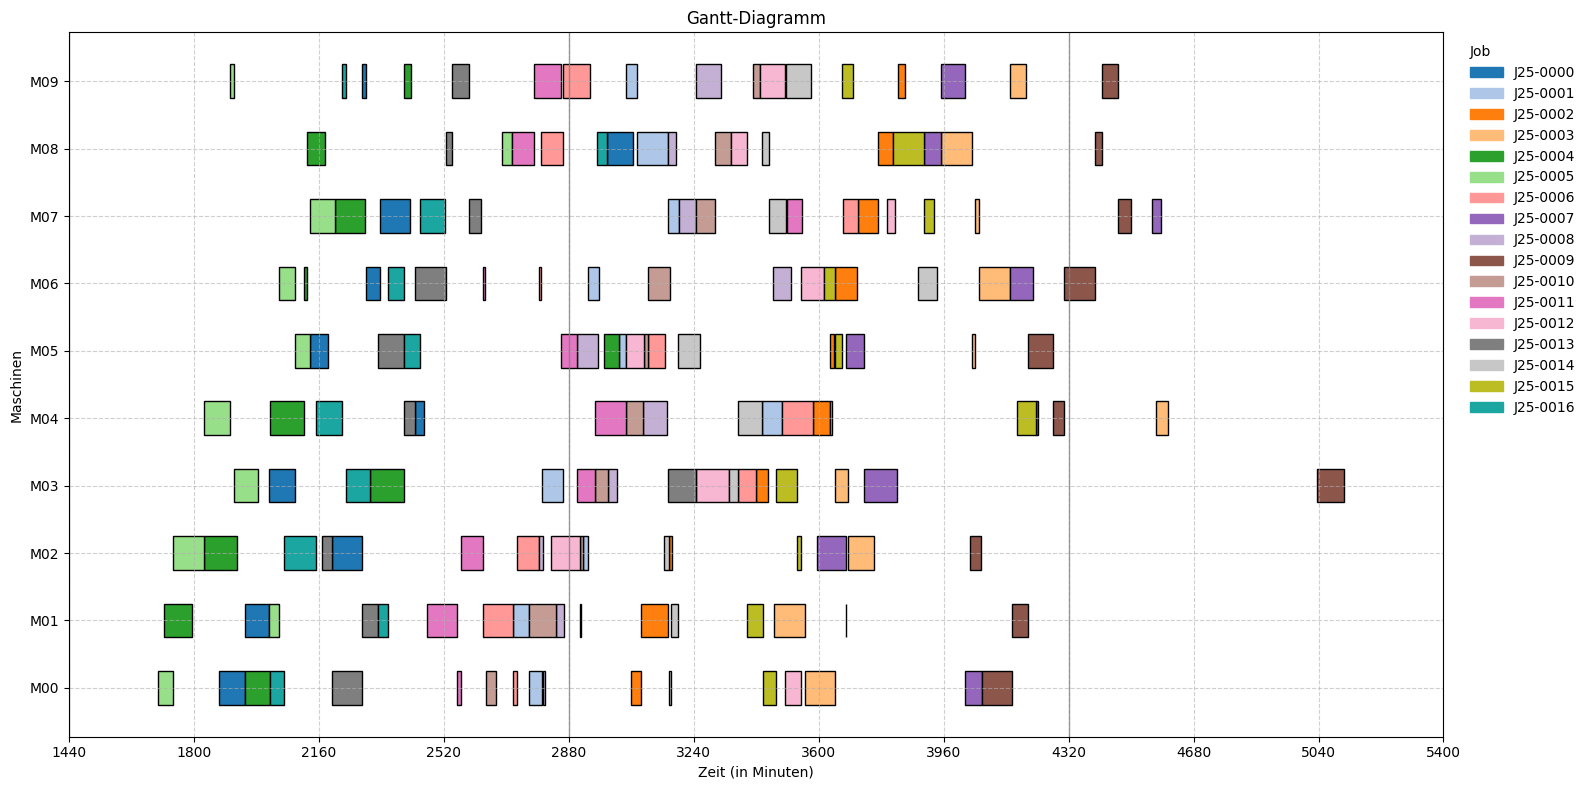

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [16]:
gantt.get_plot(df_schedule, perspective="Machine")
#df_schedule_with_info = enrich_schedule_dframe(df_schedule, df_jobs_times)
check.check_core_schedule_constraints(df_schedule)
check.is_start_correct(df_schedule, df_jobs_times_current)
check.is_duration_correct(df_schedule)


### Simulation

In [17]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time=day_end)

[Day 1 04:17:00] Job J25-0005 started on M00
[Day 1 04:35:00] Job J25-0004 started on M01
[Day 1 05:13:00] Job J25-0005 finished on M00 (after 56 minutes)
[Day 1 05:13:00] Job J25-0005 started on M02
[Day 1 06:07:00] Job J25-0004 finished on M01 (after 92 minutes)
[Day 1 06:57:00] Job J25-0005 finished on M02 (after 104 minutes)
[Day 1 06:57:00] Job J25-0004 started on M02
[Day 1 06:57:00] Job J25-0005 started on M04
[Day 1 07:11:00] Job J25-0000 started on M00
[Day 1 07:59:00] Job J25-0005 finished on M04 (after 62 minutes)
[Day 1 07:59:00] Job J25-0005 started on M09
[Day 1 08:04:00] Job J25-0000 finished on M00 (after 53 minutes)
[Day 1 08:11:00] Job J25-0005 finished on M09 (after 12 minutes)
[Day 1 08:11:00] Job J25-0005 started on M03
[Day 1 08:27:00] Job J25-0000 started on M01
[Day 1 08:41:00] Job J25-0004 finished on M02 (after 104 minutes)
[Day 1 08:41:00] Job J25-0004 started on M00
[Day 1 08:57:00] Job J25-0005 finished on M03 (after 46 minutes)
[Day 1 09:25:00] Job J25-000

In [18]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,1871.0,53.0,1924.0
1,J25-0000,1,M01,1947.0,58.0,2005.0
2,J25-0000,2,M03,2016.0,73.0,2089.0
3,J25-0000,3,M05,2136.0,48.0,2184.0
4,J25-0000,4,M02,2209.0,71.0,2280.0
5,J25-0000,5,M09,2284.0,9.0,2293.0
...,...,...,...,...,...,...
57,J25-0016,3,M09,2262.0,9.0,2271.0
58,J25-0016,4,M03,2271.0,59.0,2330.0
59,J25-0016,5,M01,2341.0,29.0,2370.0


In [19]:
executed_workflow = JobOperationWorkflowCollection.from_dataframe(df_execution)
executed_workflow.to_dataframe()

,Job,Routing_ID,Operation,Start,Processing Time,End
0,J25-0000,None,0,1871,53,1924
1,J25-0000,None,1,1947,58,2005
2,J25-0000,None,2,2016,73,2089
3,J25-0000,None,3,2136,48,2184
4,J25-0000,None,4,2209,71,2280
5,J25-0000,None,5,2284,9,2293
...,...,...,...,...,...,...
57,J25-0016,None,3,2262,9,2271
58,J25-0016,None,4,2271,59,2330
59,J25-0016,None,5,2341,29,2370


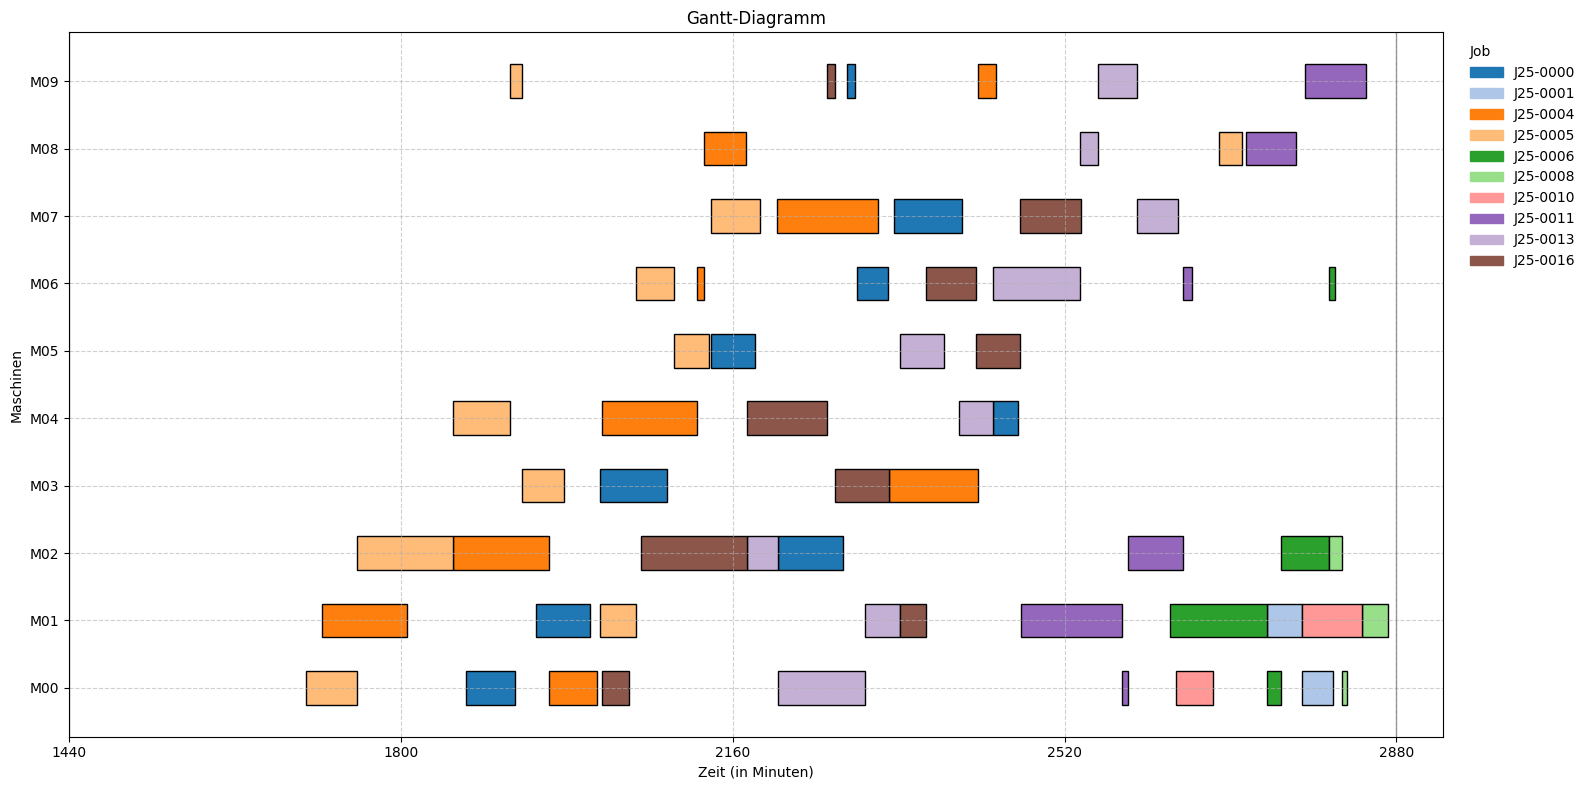

In [20]:
gantt.get_plot(df_execution, perspective="Machine")

In [21]:
df_active = simulation.get_active_operations_df()
active_workflow = JobOperationWorkflowCollection.from_dataframe(df_active)
active_workflow.to_dataframe()

,Job,Routing_ID,Operation,Start,Processing Time,End
0,J25-0001,None,2,2811,74,2885
1,J25-0006,None,4,2813,71,2884
2,J25-0011,None,6,2857,49,2906
3,J25-0012,None,0,2829,70,2899


In [22]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
not_started_workflow = JobOperationWorkflowCollection.from_dataframe(df_not_started)
not_started_workflow.to_dataframe()

,Job,Routing_ID,Operation,Start,Processing Time,End
0,J25-0000,None,9,2991,74,3065
1,J25-0001,None,3,2922,13,2935
2,J25-0001,None,4,2935,32,2967
3,J25-0001,None,5,3025,21,3046
4,J25-0001,None,6,3046,32,3078
5,J25-0001,None,7,3078,89,3167
...,...,...,...,...,...,...
97,J25-0015,None,5,3647,21,3668
98,J25-0015,None,6,3668,32,3700
99,J25-0015,None,7,3814,89,3903


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [23]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [25]:
# New and previous jobs that must be scheduled

job_ids = list(df_not_started.Job.unique())
current_job_times_collection = job_times_collection.get_subset(earliest_start=day_start, planable_job_ids=job_ids)
df_jobs_times_current = current_job_times_collection.to_dataframe()
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Deadline
0,J25-0000,8,0,1440,3065
1,J25-0001,6,49,1440,3493
2,J25-0002,0,116,1440,3849
3,J25-0003,2,160,1440,4606
4,J25-0004,3,203,1440,3025
5,J25-0006,9,695,1440,3714
...,...,...,...,...,...
32,J25-0033,2,2524,2880,5374
33,J25-0034,8,2579,2880,3965
34,J25-0035,5,2589,2880,4243


In [26]:
current_jssp_collection = JobOperationProblemCollection.from_collections(current_job_times_collection, routings_collection)
current_jssp_collection.remove_operations_from_workflows([executed_workflow, active_workflow])

df_jssp_current = current_jssp_collection.to_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,9,M08,74
1,J25-0001,6,3,M02,13
2,J25-0001,6,4,M06,32
3,J25-0001,6,5,M05,21
4,J25-0001,6,6,M09,32
5,J25-0001,6,7,M08,89
...,...,...,...,...,...
317,J25-0038,3,4,M06,9
318,J25-0038,3,5,M08,52
319,J25-0038,3,6,M07,85


### Scheduling Preparation

In [ ]:
# jssp dict and job times information dict
job_ops_dict = get_job_ops_dict(df_jssp_current)
times_dict = get_times_dict(df_jobs_times_current)

In [ ]:
active_ops = get_active_ops(df_active)
active_ops

In [ ]:
previous_schedule = schedule
df_previous_schedule = df_schedule

In [ ]:
schedule

In [ ]:
-

### Scheduling (Rescheduling)

#### a) Simple Scheduling

In [ ]:
schedule, experiment_log = solve_jssp_lateness_with_start_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=None,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=1,
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)


In [ ]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

In [ ]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

In [ ]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

### b) with 'start' deviation penalty

In [ ]:
schedule, experiment_log = solve_jssp_lateness_with_start_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=previous_schedule,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=(1/2),                  # 50% Lateness+, 50% Deviation
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"\nSum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

In [ ]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

### c) with 'order on machines' deviation penalty

In [ ]:
schedule, experiment_log = solve_jssp_lateness_with_order_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=previous_schedule,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=(1/2),                  # 50% Lateness+, 50% Deviation
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.001
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"\nSum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

In [ ]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

In [ ]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

#### Check the conditions of the combined data set from the simulation data with the new schedule

In [ ]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)

### Simulation

In [ ]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time = day_end)

In [ ]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

In [ ]:
gantt.get_plot(df_execution2, perspective="Machine")

In [ ]:
df_active2 = simulation.get_active_operations_df()
df_active2

#### Check the conditions of the combined data set from the two simulation data sets

In [ ]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)